# Import

In [1]:
'''
    提示：因为要求使用 mindquantum==0.9.0 但 stabilizer Simulator 功能尚不完善
    所以 只能通过mindquantum实现 小比特的 线路求解
'''
import numpy as np    
from mindquantum.core.gates import Z, H, X, S, CNOT
from mindquantum.simulator import Simulator  
from mindquantum.core.circuit import Circuit 
from mindquantum.core.operators import QubitOperator, Hamiltonian, commutator
import networkx as nx
from openqaoa.problems import MaximumCut
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.utilities import plot_graph
import copy
import random

# Functions

### hamil: the Hamiltonian

In [2]:
'''
   构建问题的哈密顿量，Hc = 1/2 ∑(wZZ)
   qubo 是通过 openqaoa.problems 的 MaximumCut 生成的 maxcut graph
'''
def hamil(qubo):
    def hamil_str(pos):
        result = f'Z{pos[0]} Z{pos[1]}'
        return result

    ising = qubo.terms
    weights = qubo.weights  

    hamil_op = QubitOperator()
    
    for index,term in enumerate(ising):
        hamil_op += QubitOperator(hamil_str(term), weights[index]/2)
    
    return hamil_op

### derivative:

In [3]:
'''
   求 [Hc,Ac] 对当前线路的期望值 -i <ψ| [Hc,Ac] |ψ>
   因为结果的虚部一定为0，所以最后只取实部
'''

def derivative(qubo, qubits, mixer, circ):
    commu = (-1j) * commutator(hamil(qubo), QubitOperator(mixer))
    ham = Hamiltonian(commu)
    
    sim = Simulator('mqvector', qubits)
    expectation = sim.get_expectation(ham, circ)
    return expectation.real

### Graph:Make and Plot

In [4]:
'''
   用 MaximumCut 接口生成自定义的 maxcut graph
   qubo.weights 和 qubo.terms 可以获取该 graph 的权重列表和连线列表
   只提供 uniform 权重分布
   draw_graph: 图的绘制
'''
def graph_complete(nodes):
    G = nx.complete_graph(nodes)

    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = np.random.uniform(0, 1)
    return MaximumCut(G).qubo

def draw_graph(qubo):
    G = nx.Graph()
    for edge, weight in zip(qubo.terms, qubo.weights):
        G.add_edge(edge[0], edge[1], weight=weight)
    plot_graph(G)

### extract_numbers: A tool

In [5]:
'''
    一种提取工具
'''
import re
def extract_numbers(s):
    match = re.match(r'(\D+)(\d+) (\D+)(\d+)', s)
    if match:
        # 提取匹配的数字部分
        n = int(match.group(2))
        m = int(match.group(4))
        return n, m

### Rzy Gate

In [6]:
from mindquantum.core.gates import gene_univ_parameterized_gate
import numba
'''
   定义 Rzy 门，Rzy(θ) = exp(-i θ/2 (Y⊗Z) )
   .on([a,b])
   当 a>b, 作用 exp(-i θ/2 (Y⊗Z) )
   当 a<b, 作用 exp(-i θ/2 (Z⊗Y) )
   因为mindquantum 0.9.0 中的双比特旋转门无法实现 非对称。只能通过 该接口构建
'''
def matrix(alpha):
    ep = np.cos(alpha/2)
    em = np.sin(alpha/2)
    return np.array([
        [ep + 0.0j, 0.0j, -em + 0.0j, 0.0j],
        [0.0j, ep + 0.0j, 0.0j, em + 0.0j],
        [em + 0.0j, 0.0j, ep + 0.0j, 0.0j],
        [0.0j, -em + 0.0j, 0.0j, ep + 0.0j]
    ])
def diff_matrix(alpha):
    ep = -0.5 * np.sin(alpha/2)
    em = 0.5 * np.cos(alpha/2)
    return np.array([
        [ep + 0.0j, 0.0j, -em + 0.0j, 0.0j],
        [0.0j, ep + 0.0j, 0.0j, em + 0.0j],
        [em + 0.0j, 0.0j, ep + 0.0j, 0.0j],
        [0.0j, -em + 0.0j, 0.0j, ep + 0.0j]
    ])
Rzy = gene_univ_parameterized_gate('Rzy', matrix, diff_matrix)

# Adapt Clifford Algorithm

In [7]:
'''
    t: 随机初试值
    第一层的 mixers: Ya Zb, 后面的 mixers: Za Yb
    ADAPT-Clifford 分为 randomized 和 deterministic 方法
        randomized: 随机一个初始值 t
        deterministic: 所有初试值都尝试一遍，然后取最小的期望值
'''
def adapt_clifford(nodes, t, qubo):
    all_num = list(range(nodes))
    l = 0
    a = [t]
    b = [n for n in all_num if n!= t]
    mixers = [f'Y{i} Z{j}' for i in a for j in b]

    circ = Circuit()
    for i in range(nodes):
        circ += H.on(i)
    circ.barrier()
    circ += Z.on(t)

    while True:
        gradients = []
        for mixer in mixers:
            gradients.append(derivative(qubo, nodes, mixer, circ)) 
        mix = mixers[np.argmax(gradients)]

        if l == 0:
            k,j=extract_numbers(mix)
            circ += Rzy(-np.pi/2).on([j,k])
            circ.barrier()
        if l > 0:
            k,j=extract_numbers(mix)
            circ += Rzy(-np.pi/2).on([k,j])
            circ.barrier()
        
        a.append(j)
        b.remove(j)
        mixers = [f'Z{i} Y{j}' for i in a for j in b]

        l += 1
        if l == nodes - 1:
            return circ

## 补全法adapt(消除随机误差)  
def deterministic(qubo,nodes):
    STATE = []
    RES = []
    for i in range(nodes):
        circ = adapt_clifford(nodes, i, qubo)
        sim = Simulator('mqvector', nodes)
        exp = sim.get_expectation(Hamiltonian(hamil(qubo)), circ)
    
        STATE.append(circ.get_qs(ket=True))
        RES.append(exp.real)      
    return STATE[np.argmin(RES)], min(RES)

## 随机法adapt(初始随机值产生误差)  
def randomized(qubo,nodes):
    t = random.choice(list(range(nodes)))

    circ = adapt_clifford(nodes,t,qubo)
    sim = Simulator('mqvector', nodes)
    exp = sim.get_expectation(Hamiltonian(hamil(qubo)), circ)
    return circ.get_qs(ket=True), exp.real

# Set Test Problem

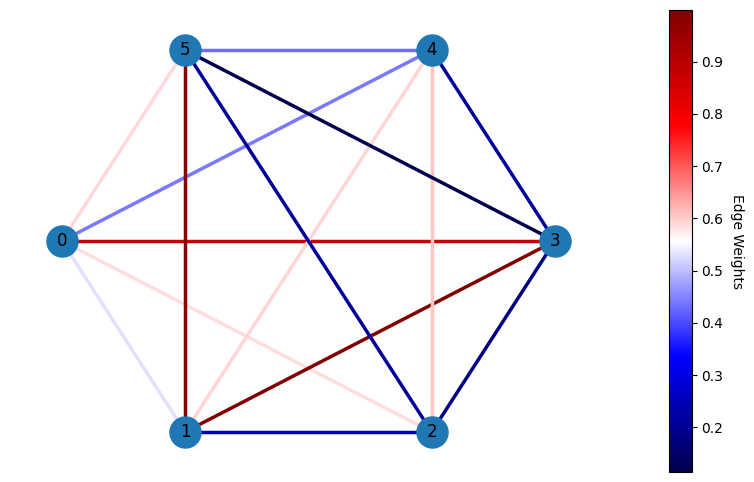

In [9]:
NODES = 6
qubo = graph_complete(NODES)
draw_graph(qubo)

In [10]:
%%time
state,energy = randomized(qubo,NODES)
print(state)
print(energy)

√2/2¦010011⟩
-√2/2¦101100⟩
-1.7179187705276238
CPU times: total: 62.5 ms
Wall time: 57 ms


In [11]:
%%time
state,energy = deterministic(qubo,NODES)
print(state)
print(energy)

-√2/2¦010011⟩
√2/2¦101100⟩
-1.7179187705276238
CPU times: total: 344 ms
Wall time: 324 ms


In [12]:
ground_state_energy, ground_state_configuration = ground_state_hamiltonian(qubo.hamiltonian)
print(ground_state_energy/2, ground_state_configuration)

-1.717918770527623 ['110010', '001101']


In [5]:
def Hc_matrix(qubo,nodes):
    I = np.array([[1,0],[0,1]])
    Z = np.array([[1,0],[0,-1]])

    def Pro(edge):
        def string(nodes, edge):
            result = ['I'] * nodes
            i, j = edge
            result[i] = 'Z'
            result[j] = 'Z'
            return ''.join(result)
        str1 = string(nodes, edge)
        
        for i in range(len(str1)):
            if i==0:
                if str1[i] == 'I':
                    res = I
                else: res = Z
            else:
                if str1[i] == 'I':
                    res = np.kron(res,I)
                else: res = np.kron(res,Z)
        return res
    k=0
    for i in range(len(qubo.terms)):
        k += qubo.weights[i]*Pro(qubo.terms[i])
    return k/2
    
def state_vector(arr):
    p = list(arr)
    P = [0 if x == 1 else 1 for x in p]
    
    pos = np.array([[0],[1]],dtype=complex)
    neg = np.array([[1],[0]],dtype=complex)
    
    def Pro(l):
        for i in range(len(l)):
            if i == 0:
                if l[i] == 0:
                    res = neg
                else: res = pos
            else:
                if l[i] == 0:
                    res = np.kron(res, neg)
                else: res = np.kron(res, pos)
        return res
    return 1/np.sqrt(2) * (Pro(p)-Pro(P))

In [10]:
import cvxpy as cp
def GW(qubo,times,nodes):
    
    terms = qubo.terms
    weights = qubo.weights
    W = np.zeros((nodes, nodes))
    for i in range(len(terms)):
        W[terms[i][0], terms[i][1]] = weights[i]
        W[terms[i][1], terms[i][0]] = weights[i]

    X_v = cp.Variable((nodes,nodes), symmetric=True)
    obj = cp.Maximize(cp.sum(cp.multiply(W,(1-X_v))))
    cons = [X_v >> 0]
    cons += [X_v[i,i] == 1 for i in range(nodes)]

    prob = cp.Problem(obj,cons)
    prob.solve()
    X_opt = X_v.value
    e_vals,e_vecs = np.linalg.eigh(X_opt)

    res = []
    ass = []
    for time in range(times):
        r = np.random.randn(nodes)
        r = r/np.linalg.norm(r)

        assig = np.sign(e_vecs.T @ r)
        assig[assig == -1] = 0
        ass.append(assig)
        
        A = [i for i in range(nodes) if assig[i] > 0]
        B = [i for i in range(nodes) if assig[i] <= 0]
        cut = sum(W[i, j] for i in A for j in B if W[i, j] > 0)
        res.append(cut)

    partition = ass[np.argmax(res)]

    exp = np.dot(np.conj(state_vector(partition)).T, np.dot(Hc_matrix(qubo,nodes),state_vector(partition)) )
    return partition,exp.real[0][0]